In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler

from scripts import (
    load_joined_data,
    split_data,
    cap_outliers,
    remove_seasonality_ia,
    restore_seasonality_ia,
    add_lags,
)

START = datetime(2021, 4, 1, 9, 30)
END = datetime(2022, 4, 1, 16, 0)
BUCKET = 600  # seconds

COLUMNS = ['VOLUME_fut', 'VOLUME_etf', 'VOLUME_opt']
TARGET = 'VOLUME_fut_target'

# Loading data

In [2]:
# ts = load_joined_data(common_kwargs=dict(start=START, end=END, bucket=BUCKET))

In [3]:
# load cached data
ts = load_joined_data(
    pd.read_csv('./data/etf_nq.csv', index_col='Time'),
    pd.read_csv('./data/fut_nq.csv', index_col='Time'),
    pd.read_csv('./data/opt_nq.csv', index_col='Time'),
)
ts

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target
0,2021-04-01 09:40:00,31967,5787283,20914,940,31967
1,2021-04-01 09:50:00,13194,3001767,14998,950,13194
2,2021-04-01 10:00:00,9774,1523707,9644,1000,9774
3,2021-04-01 10:10:00,26026,3199697,17938,1010,26026
4,2021-04-01 10:20:00,10889,2662730,12092,1020,10889
...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,8872,1283681,18724,1520,8872
9847,2022-03-31 15:30:00,12924,1501646,12523,1530,12924
9848,2022-03-31 15:40:00,16582,1970892,18835,1540,16582
9849,2022-03-31 15:50:00,13761,2629317,15626,1550,13761


# Raw data overview

<AxesSubplot:xlabel='Time'>

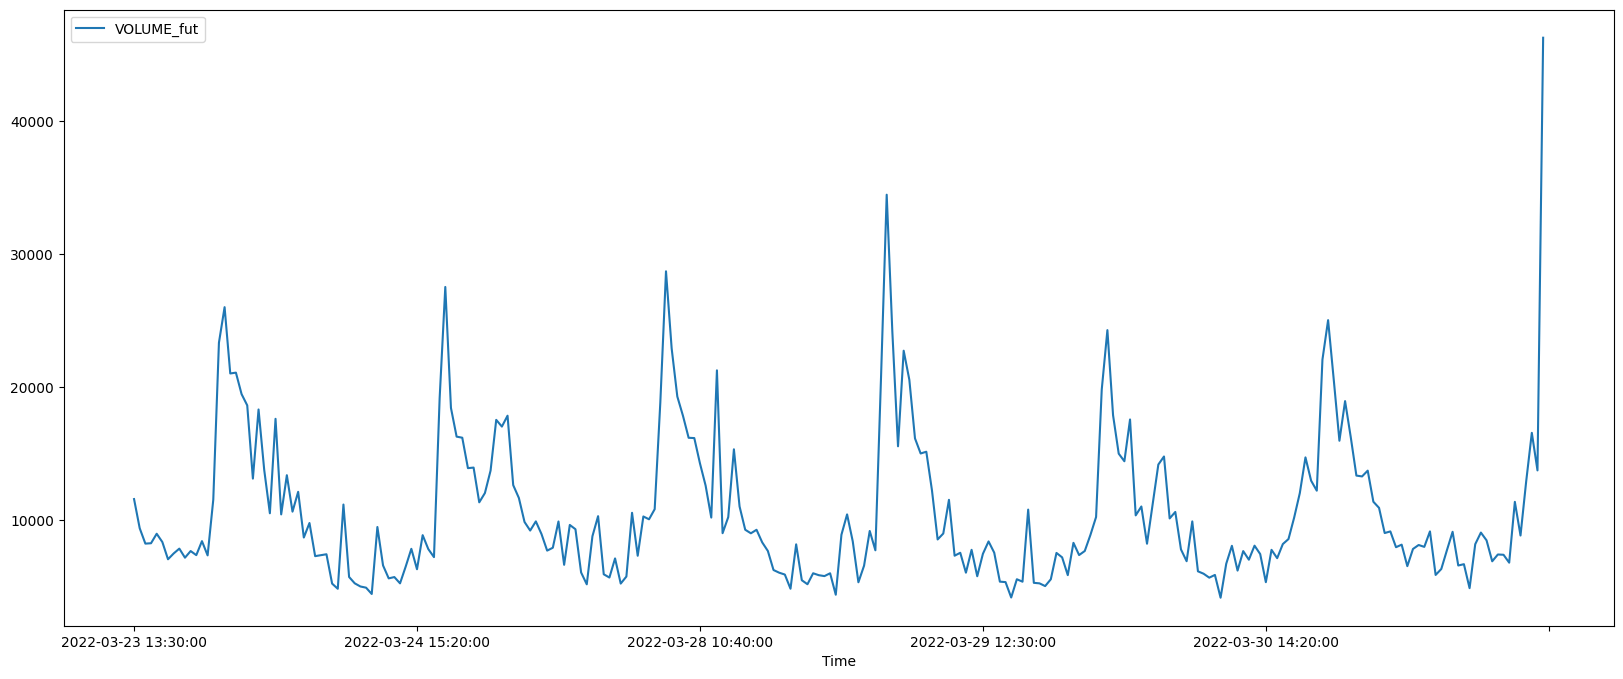

In [4]:
ts.iloc[-250:].plot(y='VOLUME_fut', x='Time', figsize=[20, 8])

## Autocorrelation

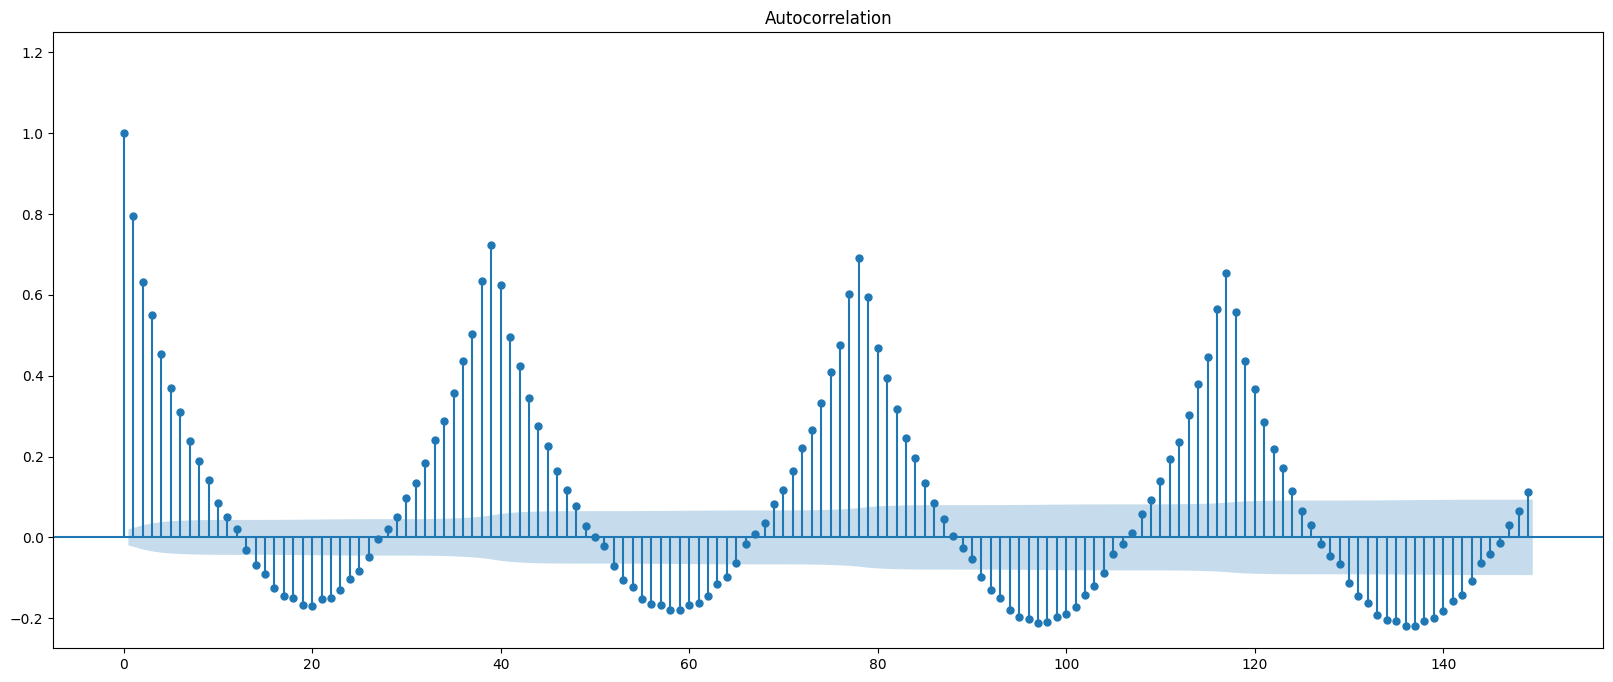

In [5]:
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(ts['VOLUME_fut'], ax=ax, lags=np.arange(150), auto_ylims=True)

In [6]:
# fig, ax = plt.subplots(figsize=(20, 8))
# plt_pacf = plot_pacf(ts['VOLUME_fut'], ax=ax, lags=np.arange(200), auto_ylims=True, method='ywm')

## Intraday seasonality

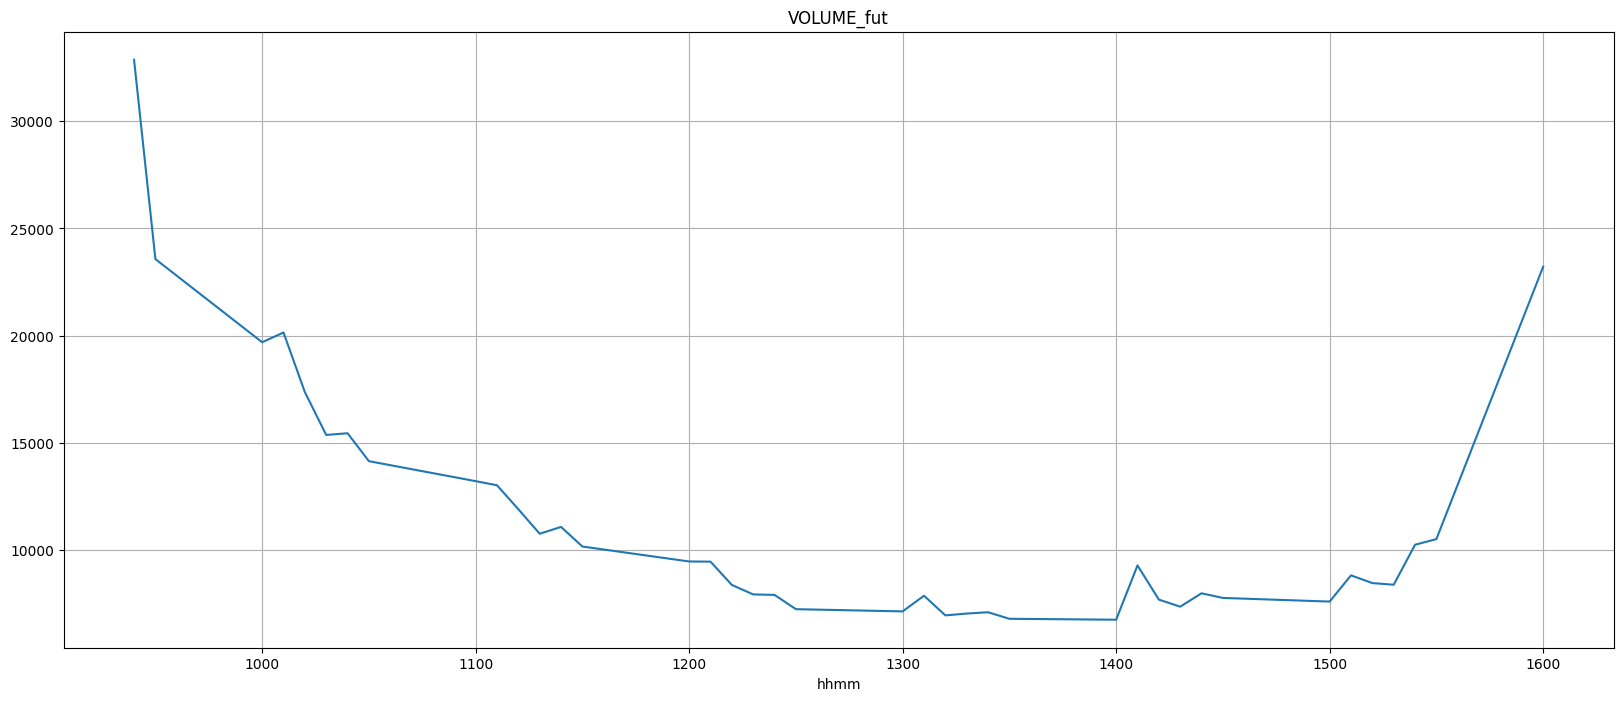

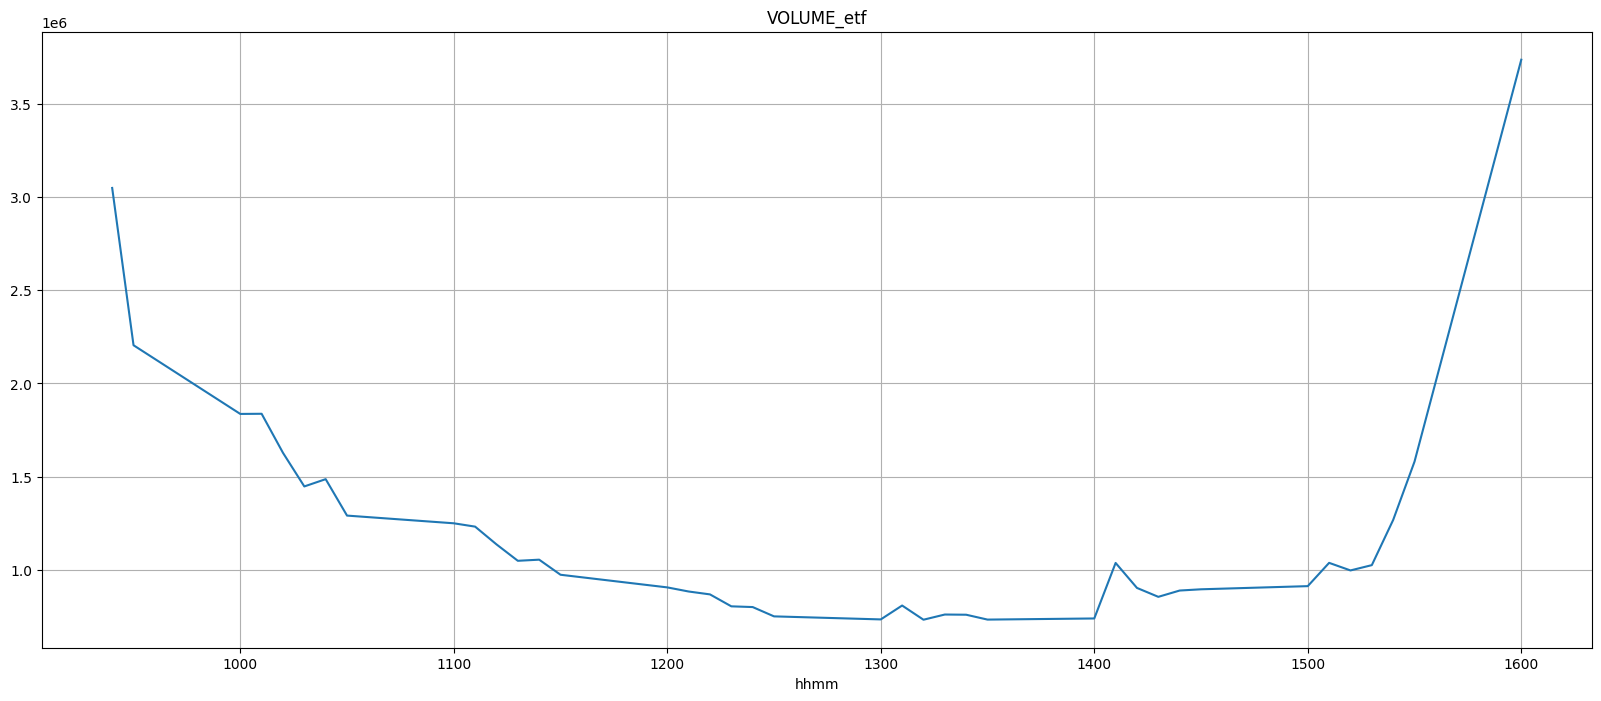

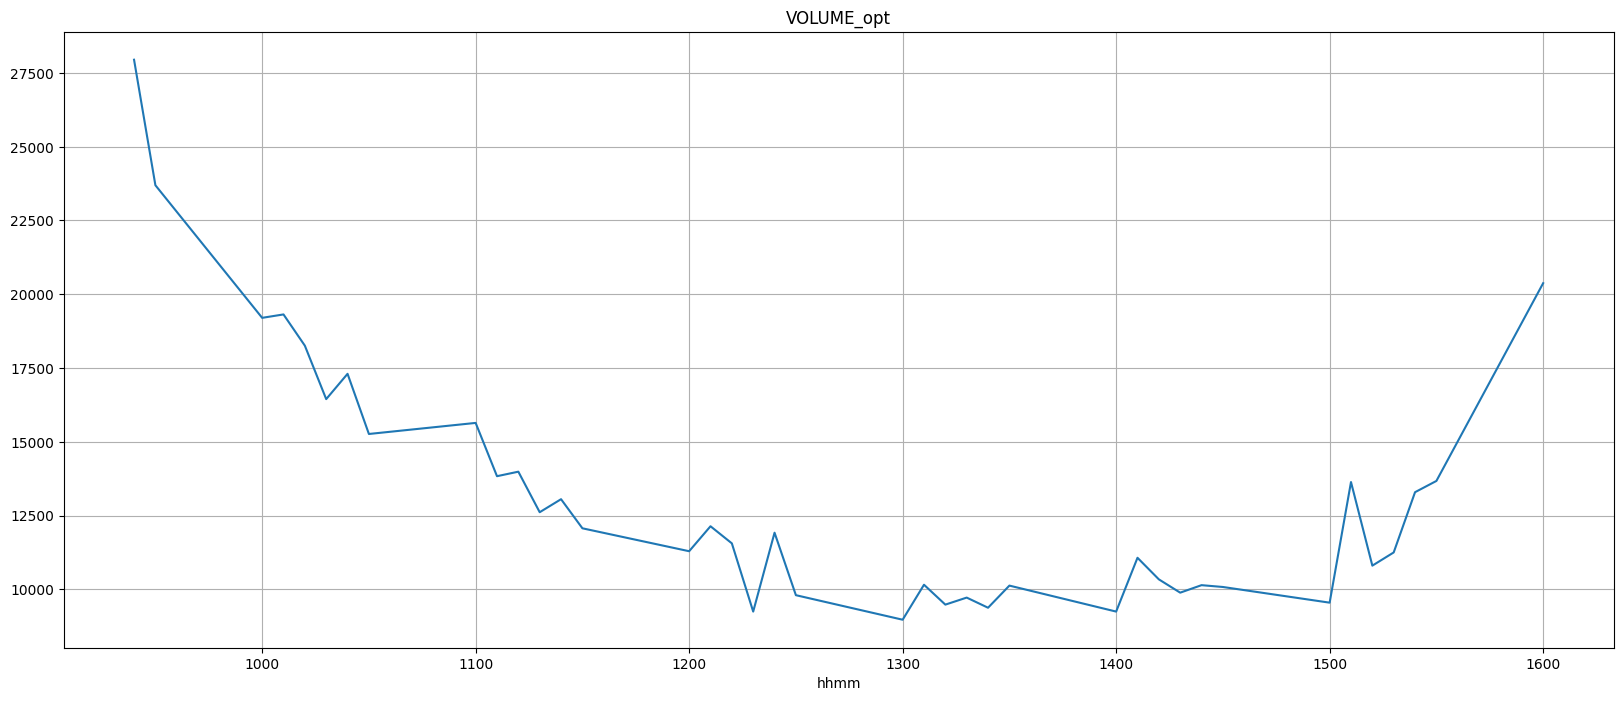

In [7]:
# Volume profile (average)
ts_agg = ts.groupby('hhmm').mean()

for column in COLUMNS:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax = ts_agg[column].plot(ax=ax, title=column)
    ax.grid()

# Preparing data

In [8]:
# split data
train_indexes, val_indexes, test_indexes = split_data(ts, val_size = 0.1, test_size = 0.1)

# cap outliers
ts = cap_outliers(ts, train_indexes, COLUMNS, std_num=4)

# remove seasonality
df = remove_seasonality_ia(ts, COLUMNS, bins=39, window_days=20)

# scale data
scaler = MinMaxScaler()

train = df.loc[train_indexes, COLUMNS]
val = df.loc[val_indexes, COLUMNS]
test = df.loc[test_indexes, COLUMNS]

df.loc[train_indexes, COLUMNS] = scaler.fit_transform(train)
df.loc[val_indexes, COLUMNS] = scaler.transform(val)
df.loc[test_indexes, COLUMNS] = scaler.transform(test)

df

,VOLUME_fut,VOLUME_etf,VOLUME_opt,VOLUME_fut_target,VOLUME_fut_agg
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
9846,0.299234,0.322628,0.399231,-1088.95,9960.95
9847,0.382469,0.321743,0.297174,3112.50,9811.50
9848,0.436710,0.377578,0.380897,5850.40,10731.60
9849,0.369721,0.425946,0.331986,2469.05,11291.95


# Processed data overview

<AxesSubplot:>

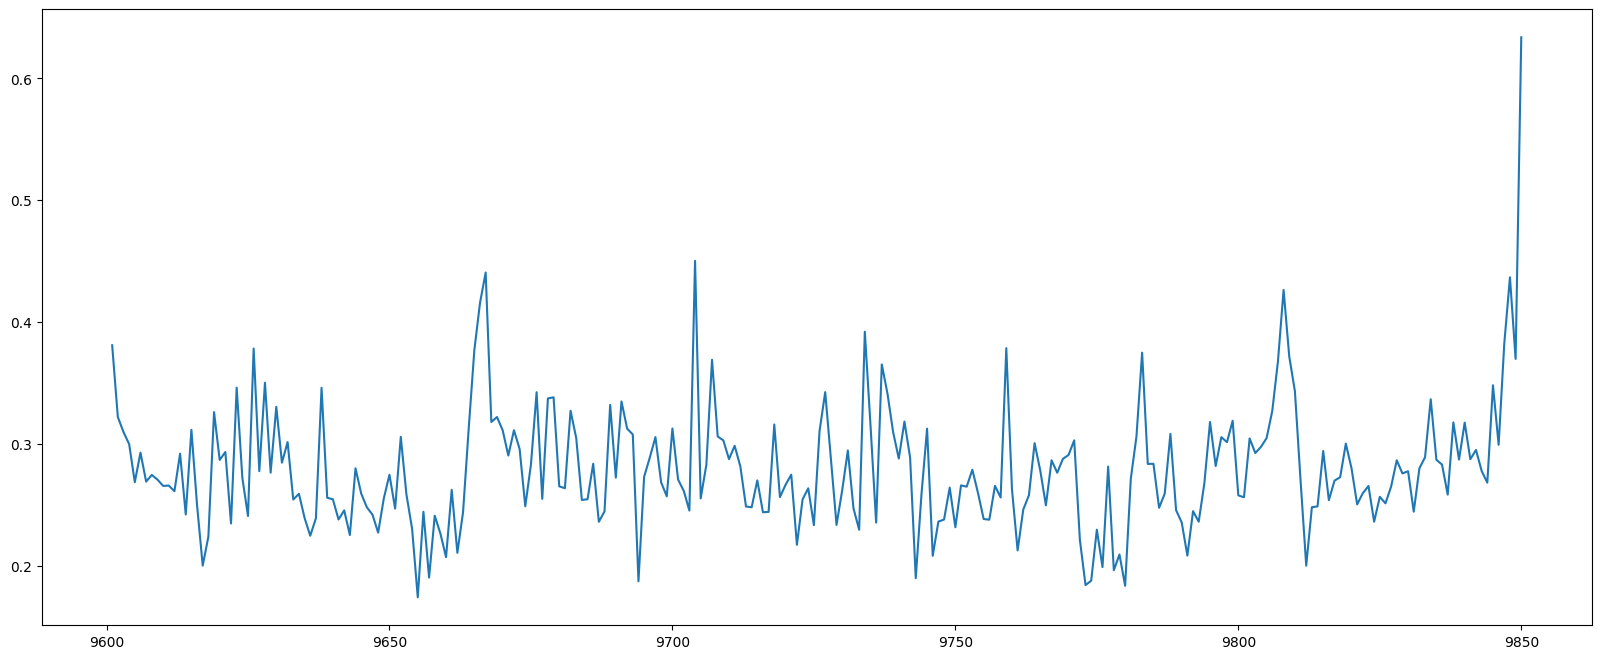

In [9]:
df['VOLUME_fut'].iloc[-250:].plot(figsize=[20, 8])

In [10]:
# # Partial autocorrelation plots
# for column in COLUMNS:
#     fig, ax = plt.subplots(figsize=(20, 8))
#     plt_pacf = plot_pacf(df[column].dropna(), ax=ax, lags=np.arange(200), auto_ylims=True, method='ywm', title=column)

# Add lags as features

In [11]:
df, lags_columns = add_lags(
    df, train_indexes, COLUMNS, periods=[1, 2, 3, 4, 38, 39, 78, 195]
)
df[lags_columns]

,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,VOLUME_fut_lag_38,VOLUME_fut_lag_39,VOLUME_fut_lag_78,VOLUME_fut_lag_195,VOLUME_etf_lag_1,VOLUME_etf_lag_2,VOLUME_etf_lag_3,VOLUME_etf_lag_4,VOLUME_etf_lag_38,VOLUME_etf_lag_39,VOLUME_etf_lag_78,VOLUME_etf_lag_195,VOLUME_opt_lag_1,VOLUME_opt_lag_2,VOLUME_opt_lag_3,VOLUME_opt_lag_4,VOLUME_opt_lag_38,VOLUME_opt_lag_39,VOLUME_opt_lag_78,VOLUME_opt_lag_195
975,0.417079,0.347085,0.293045,0.322147,0.324096,0.389872,0.335679,0.267483,0.592493,0.405472,0.322109,0.334707,0.427673,0.567808,0.514717,0.388671,0.319410,0.389250,0.297848,0.494169,0.281198,0.445175,0.484076,0.643841
976,0.484750,0.417079,0.347085,0.293045,0.379511,0.324096,0.318159,0.285332,0.698065,0.592493,0.405472,0.322109,0.427382,0.427673,0.502920,0.307297,0.588489,0.319410,0.389250,0.297848,0.249154,0.281198,0.349573,0.402524
977,0.512793,0.484750,0.417079,0.347085,0.324532,0.379511,0.301498,0.321312,0.656628,0.698065,0.592493,0.405472,0.407827,0.427382,0.414253,0.351533,0.606438,0.588489,0.319410,0.389250,0.280517,0.249154,0.323936,0.362951
978,0.291243,0.512793,0.484750,0.417079,0.410223,0.324532,0.473665,0.290855,0.406560,0.656628,0.698065,0.592493,0.421218,0.407827,0.564485,0.317911,0.394602,0.606438,0.588489,0.319410,0.272937,0.280517,0.433665,0.380491
979,0.335728,0.291243,0.512793,0.484750,0.337032,0.410223,0.359556,0.310240,0.473763,0.406560,0.656628,0.698065,0.408971,0.421218,0.414871,0.284335,0.452354,0.394602,0.606438,0.588489,0.306765,0.272937,0.446248,0.280449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9846,0.348067,0.268115,0.277756,0.295003,0.426359,0.367592,0.276272,0.246880,0.429821,0.277402,0.300861,0.320182,0.507624,0.462062,0.356503,0.278311,0.430508,0.324241,0.264198,0.271235,0.315066,0.432664,0.308608,0.301425
9847,0.299234,0.348067,0.268115,0.277756,0.371693,0.426359,0.287676,0.305755,0.322628,0.429821,0.277402,0.300861,0.342273,0.507624,0.491972,0.282940,0.399231,0.430508,0.324241,0.264198,0.270838,0.315066,0.266701,0.383216
9848,0.382469,0.299234,0.348067,0.268115,0.343206,0.371693,0.290879,0.258375,0.321743,0.322628,0.429821,0.277402,0.333295,0.342273,0.346352,0.247779,0.297174,0.399231,0.430508,0.324241,0.329119,0.270838,0.244663,0.251107
9849,0.436710,0.382469,0.299234,0.348067,0.269890,0.343206,0.302878,0.230263,0.377578,0.321743,0.322628,0.429821,0.318232,0.333295,0.376007,0.201392,0.380897,0.297174,0.399231,0.430508,0.186554,0.329119,0.264143,0.221001
